In [18]:
%matplotlib notebook
import matplotlib.pyplot as plt
import os, numpy as np
import healpy as hpx
import astropy, pyuvdata
from pyuvdata.uvbeam import uvbeam
import hera_pspec  as hp
from scipy import signal
print("pyuvdata version:", pyuvdata.__version__)
print("asropy version:",astropy.__version__)
def dB(x):
    return 10*np.log10(x)

pyuvdata version: 2.0.3.dev177+gc99d32b2
asropy version: 4.0.1.post1


In [72]:
B  = uvbeam.UVBeam()
B.read_beamfits('../HERA/HERA-Beams/NicolasFagnoniBeams/NF_HERA_Vivaldi_power_beam.fits')

In [73]:
B.interpolation_function = 'az_za_simple'
B.freq_interp_kind = 'nearest'

In [35]:
b,basis = B.interp(np.array([0]),np.array([7*np.pi/180]))
print(b.shape)
b  = b[0,0,0,:,0]


(1, 1, 2, 201, 1)


<IPython.core.display.Javascript object>


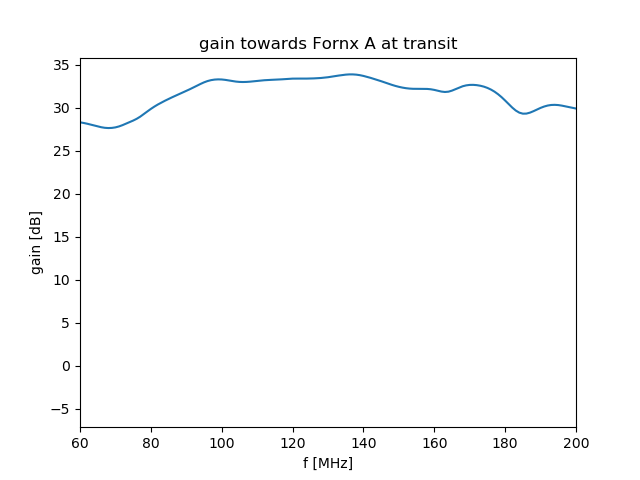

(60, 200)

In [40]:
plt.figure()
plt.plot(B.freq_array[0]/1e6,dB(b))
plt.xlabel('f [MHz]')
plt.ylabel('gain [dB]')
plt.title('gain towards Fornx A at transit')
plt.xlim(60,200)
#plt.ylim(25,35)

In [44]:
def FFT(d,dt=1):
    x = d*signal.blackmanharris(d.shape[0])
    return np.fft.fftshift(np.fft.fftfreq(len(d),d=dt)),np.fft.fftshift(np.fft.fft(x))

In [45]:
df = np.diff(B.freq_array[0])[0]
print(df/1e3)
delays,_b = FFT(b,dt=df)
cosmo = hp.conversions.Cosmo_Conversions()

1000.0


<IPython.core.display.Javascript object>


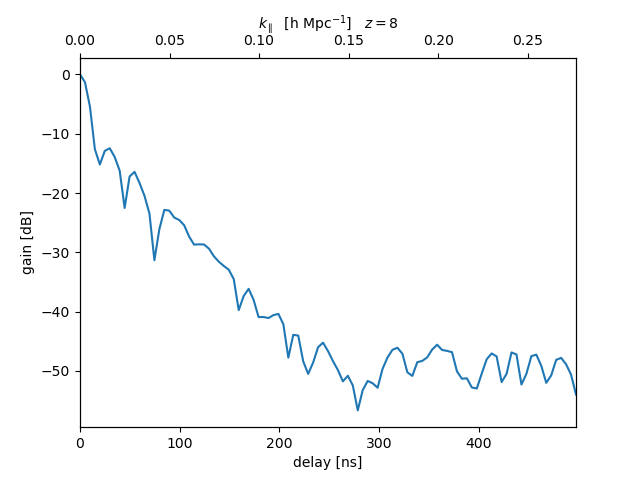

Text(0.5, 0, '$k_\\parallel$  [h Mpc$^{-1}$]   $z=8$')

In [46]:
plt.figure()
_b_norm = np.abs(_b)
_b_norm /= _b_norm.max()
plt.plot(delays*1e9,dB(_b_norm))
plt.xlabel('delay [ns]')
plt.ylabel('gain [dB]')
plt.xlim(0,delays.max()*1e9)
axt = plt.twiny()
axt.xaxis.tick_top()
plt.xlim(0,delays.max()*cosmo.tau_to_kpara(8))
plt.xlabel('$k_\parallel$  [h Mpc$^{-1}$]   $z=8$')

In [91]:
# make a map of delays
#HB = B.to_healpix(nside=128,inplace=False)

plt.figure()
for i in range(B.Naxes1):
    for j in range(B.Naxes2):
        plt.plot(delays*1e9,dB(B_delay[:,j,i]),',k')
plt.xlabel('delay [ns]')
plt.ylabel('gain [dB]')
plt.xlim(0,delays.max()*1e9)
axt = plt.twiny()
axt.xaxis.tick_top()
plt.xlim(0,delays.max()*cosmo.tau_to_kpara(8))
plt.xlabel('$k_\parallel$  [h Mpc$^{-1}$]   $z=8$')

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [86]:
def d_i(delay): #return the integer index of intput delay in ns
    return np.abs(delays*1e9 - delay).argmin()

W = signal.blackmanharris(B.Nfreqs)
W.shape += (1,1)
B_weighted = W*B.data_array[0,0,0]
B_delay = np.abs(np.fft.fftshift(np.fft.fft(B_weighted,axis=0)))


In [92]:
#mask off delays where we seem to be dominated by the windowing dynamic range
scale = B_delay[d_i(0)]
scale.shape = (1,) + scale.shape
B_f = B_delay/scale
B_delay = np.ma.masked_where(dB(B_f)<-30,B_delay)


<IPython.core.display.Javascript object>


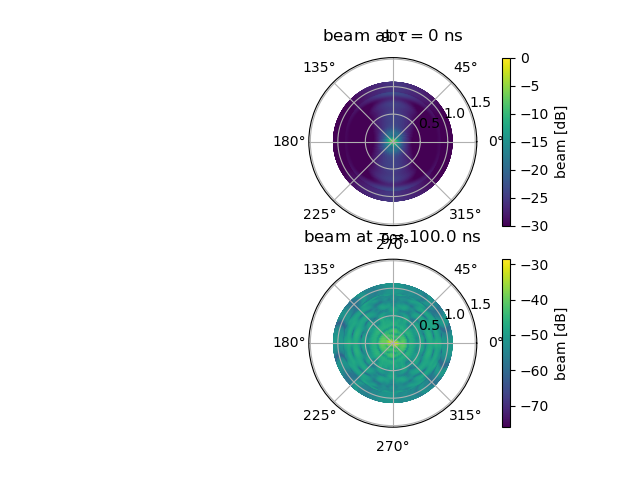

<IPython.core.display.Javascript object>


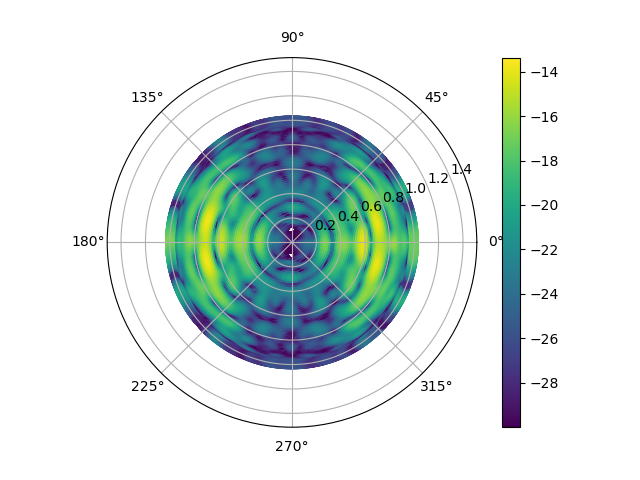

102 100


In [93]:



AZ,ZA = np.meshgrid(B.axis1_array,B.axis2_array)
mx = B_delay.max()

fig,axs = plt.subplots(2,1,subplot_kw=dict(projection='polar'))


sc = axs[0].scatter(AZ.ravel(),-np.cos(ZA.ravel()),c=dB(B_delay[d_i(0),:,:].ravel()/mx),vmax=0,vmin=-30)
cb = plt.colorbar(mappable=sc,ax=axs[0])
#plt.ylim(90,180)
cb.ax.set_ylabel('beam [dB]')
axs[0].set_title('beam at $\\tau = 0 $ ns')

B_dslice = B_delay[delay_idx,:,:]/mx

#ax = fig.add_subplot(211, projection='polar')
sc = axs[1].scatter(AZ.ravel(),-np.cos(ZA.ravel()),c=dB(B_delay[d_i(100),:,:].ravel()/mx))
cb = plt.colorbar(mappable=sc,ax=axs[1])
#plt.ylim(90,180)
cb.ax.set_ylabel('beam [dB]')
plt.title('beam at $\\tau = {d}$ ns'.format(d=np.round(delays[delay_idx]*1e9)))


fig = plt.figure()
ax = fig.add_subplot(111,projection='polar')
print(d_i(10),d_i(0))
ratio = dB(B_delay[d_i(100),:,:]) - dB(B_delay[d_i(0),:,:])
sc = ax.scatter(AZ.ravel(),-np.cos(ZA.ravel()),c=ratio.ravel())
cb = plt.colorbar(mappable=sc,ax=ax)

<IPython.core.display.Javascript object>


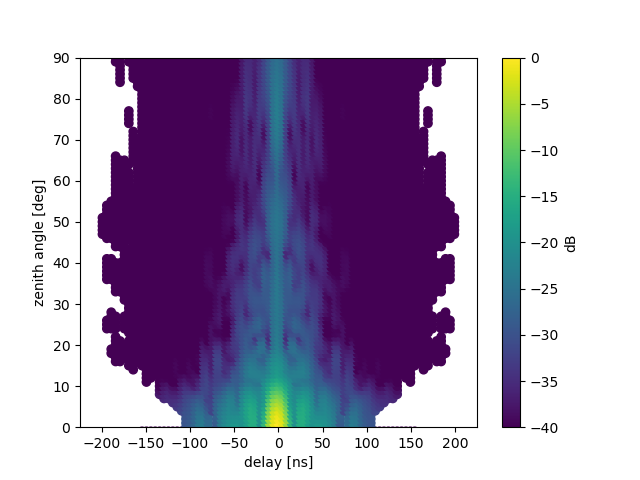

Text(0, 0.5, 'dB')

In [94]:
bmax = np.max(B_delay/mx,axis=2)
DEL,ZA = np.meshgrid(delays*1e9,B.axis2_array)
plt.figure()
#plt.imshow(dB(bmax),aspect='auto')
THETA = ZA-np.pi/2
ax = plt.scatter(DEL.ravel(),THETA.ravel()*180/np.pi,c=dB(bmax.T.ravel()),vmin=-40)
plt.xlabel('delay [ns]')
plt.ylabel('zenith angle [deg]')
plt.ylim(0,90)
cb = plt.colorbar()
cb.ax.set_ylabel('dB')

<IPython.core.display.Javascript object>


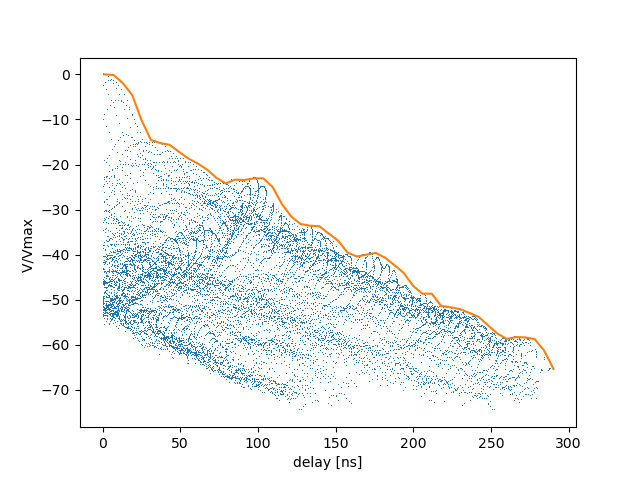

Text(0, 0.5, 'V/Vmax ')

In [168]:

bl = 30 #length of a portential baseline in m
c = 3e8 #speed of light in m/s
D = DEL + bl/c *  np.sin(THETA)*1e9 #get the _NET_ delay from baseline and beam

pos_delays = np.linspace(1,D.max(),num=100)#delays[delays>=0]*1e9
I = np.digitize(np.abs(D.ravel()),pos_delays)
DFOLD = np.zeros_like(pos_delays)
for i in np.arange(len(pos_delays)):
    if np.sum(I==i)<1:continue
    DFOLD[i] = np.max(bmax.T.ravel()[I==i])    

plt.figure()
plt.plot(np.abs(D.ravel()),dB(bmax.T.ravel()),',')
plt.plot(pos_delays,dB(DFOLD))
plt.xlabel('delay [ns]')
plt.ylabel('V/Vmax ')

<IPython.core.display.Javascript object>


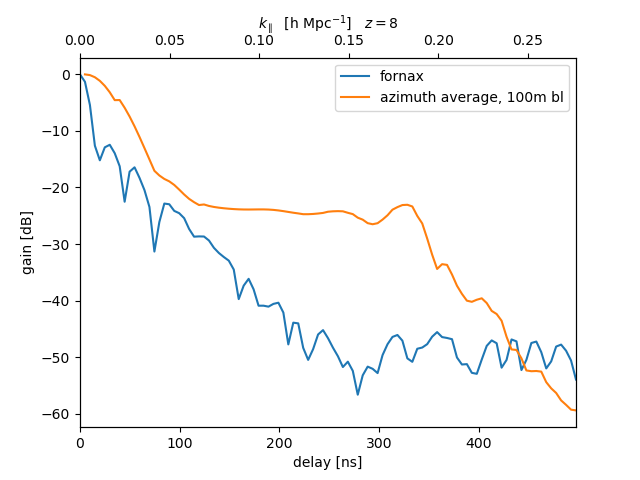

divide by zero encountered in log10


Text(0.5, 0, '$k_\\parallel$  [h Mpc$^{-1}$]   $z=8$')

In [164]:
plt.figure()
_b_norm = np.abs(_b)
_b_norm /= _b_norm.max()
plt.plot(delays*1e9,dB(_b_norm),label='fornax')
plt.plot(pos_delays,dB(DFOLD),label='azimuth average, 100m bl')
plt.legend()
plt.xlabel('delay [ns]')
plt.ylabel('gain [dB]')
plt.xlim(0,delays.max()*1e9)
axt = plt.twiny()
axt.xaxis.tick_top()
plt.xlim(0,delays.max()*cosmo.tau_to_kpara(8))
plt.xlabel('$k_\parallel$  [h Mpc$^{-1}$]   $z=8$')

In [145]:
print(cosmo.tau_to_kpara(8)/cosmo.tau_to_kpara(18))

1.4551877731254406


In [ ]:
frequency = 70e6
for beamCoeff in (beamDict['fitX'], beamDict['fitY']):
    alphaE = np.polyval(beamCoeff[0,0,:], frequency)
    betaE =  np.polyval(beamCoeff[0,1,:], frequency)
    gammaE = np.polyval(beamCoeff[0,2,:], frequency)
    deltaE = np.polyval(beamCoeff[0,3,:], frequency)
    alphaH = np.polyval(beamCoeff[1,0,:], frequency)
    betaH =  np.polyval(beamCoeff[1,1,:], frequency)
    gammaH = np.polyval(beamCoeff[1,2,:], frequency)
    deltaH = np.polyval(beamCoeff[1,3,:], frequency)
def compute_beam_pattern(az, alt):
    zaR = alt*np.pi / 180.0 
    azR = az*np.pi / 180.0
    pE = (1-(2*zaR/np.pi)**alphaE)*np.cos(zaR)**betaE + gammaE*(2*zaR/np.pi)*np.cos(zaR)**deltaE
    pH = (1-(2*zaR/np.pi)**alphaH)*np.cos(zaR)**betaH + gammaH*(2*zaR/np.pi)*np.cos(zaR)**deltaH
    rx_gain = np.sqrt((pE*np.cos(azR))**2 + (pH*np.sin(azR))**2)
    return pE, pH, rx_gain